# Test performance on an optimization benchmark (forked from `https://gitlab.com/luca.baronti/python_benchmark_functions`)

running sgd
running nesterov
running adamw
running dadapt
running cocob
running dog
running dowg
running polyak
running sgd+hgd
running nesterov+hgd
running adam+hgd
running sgd+metaopt


2024-07-21 05:57:23.296102: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__test_opt] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-21 05:58:11.253762: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m47.963463s

********************************
[Compiling module jit__test_opt] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


running adam+metaopt


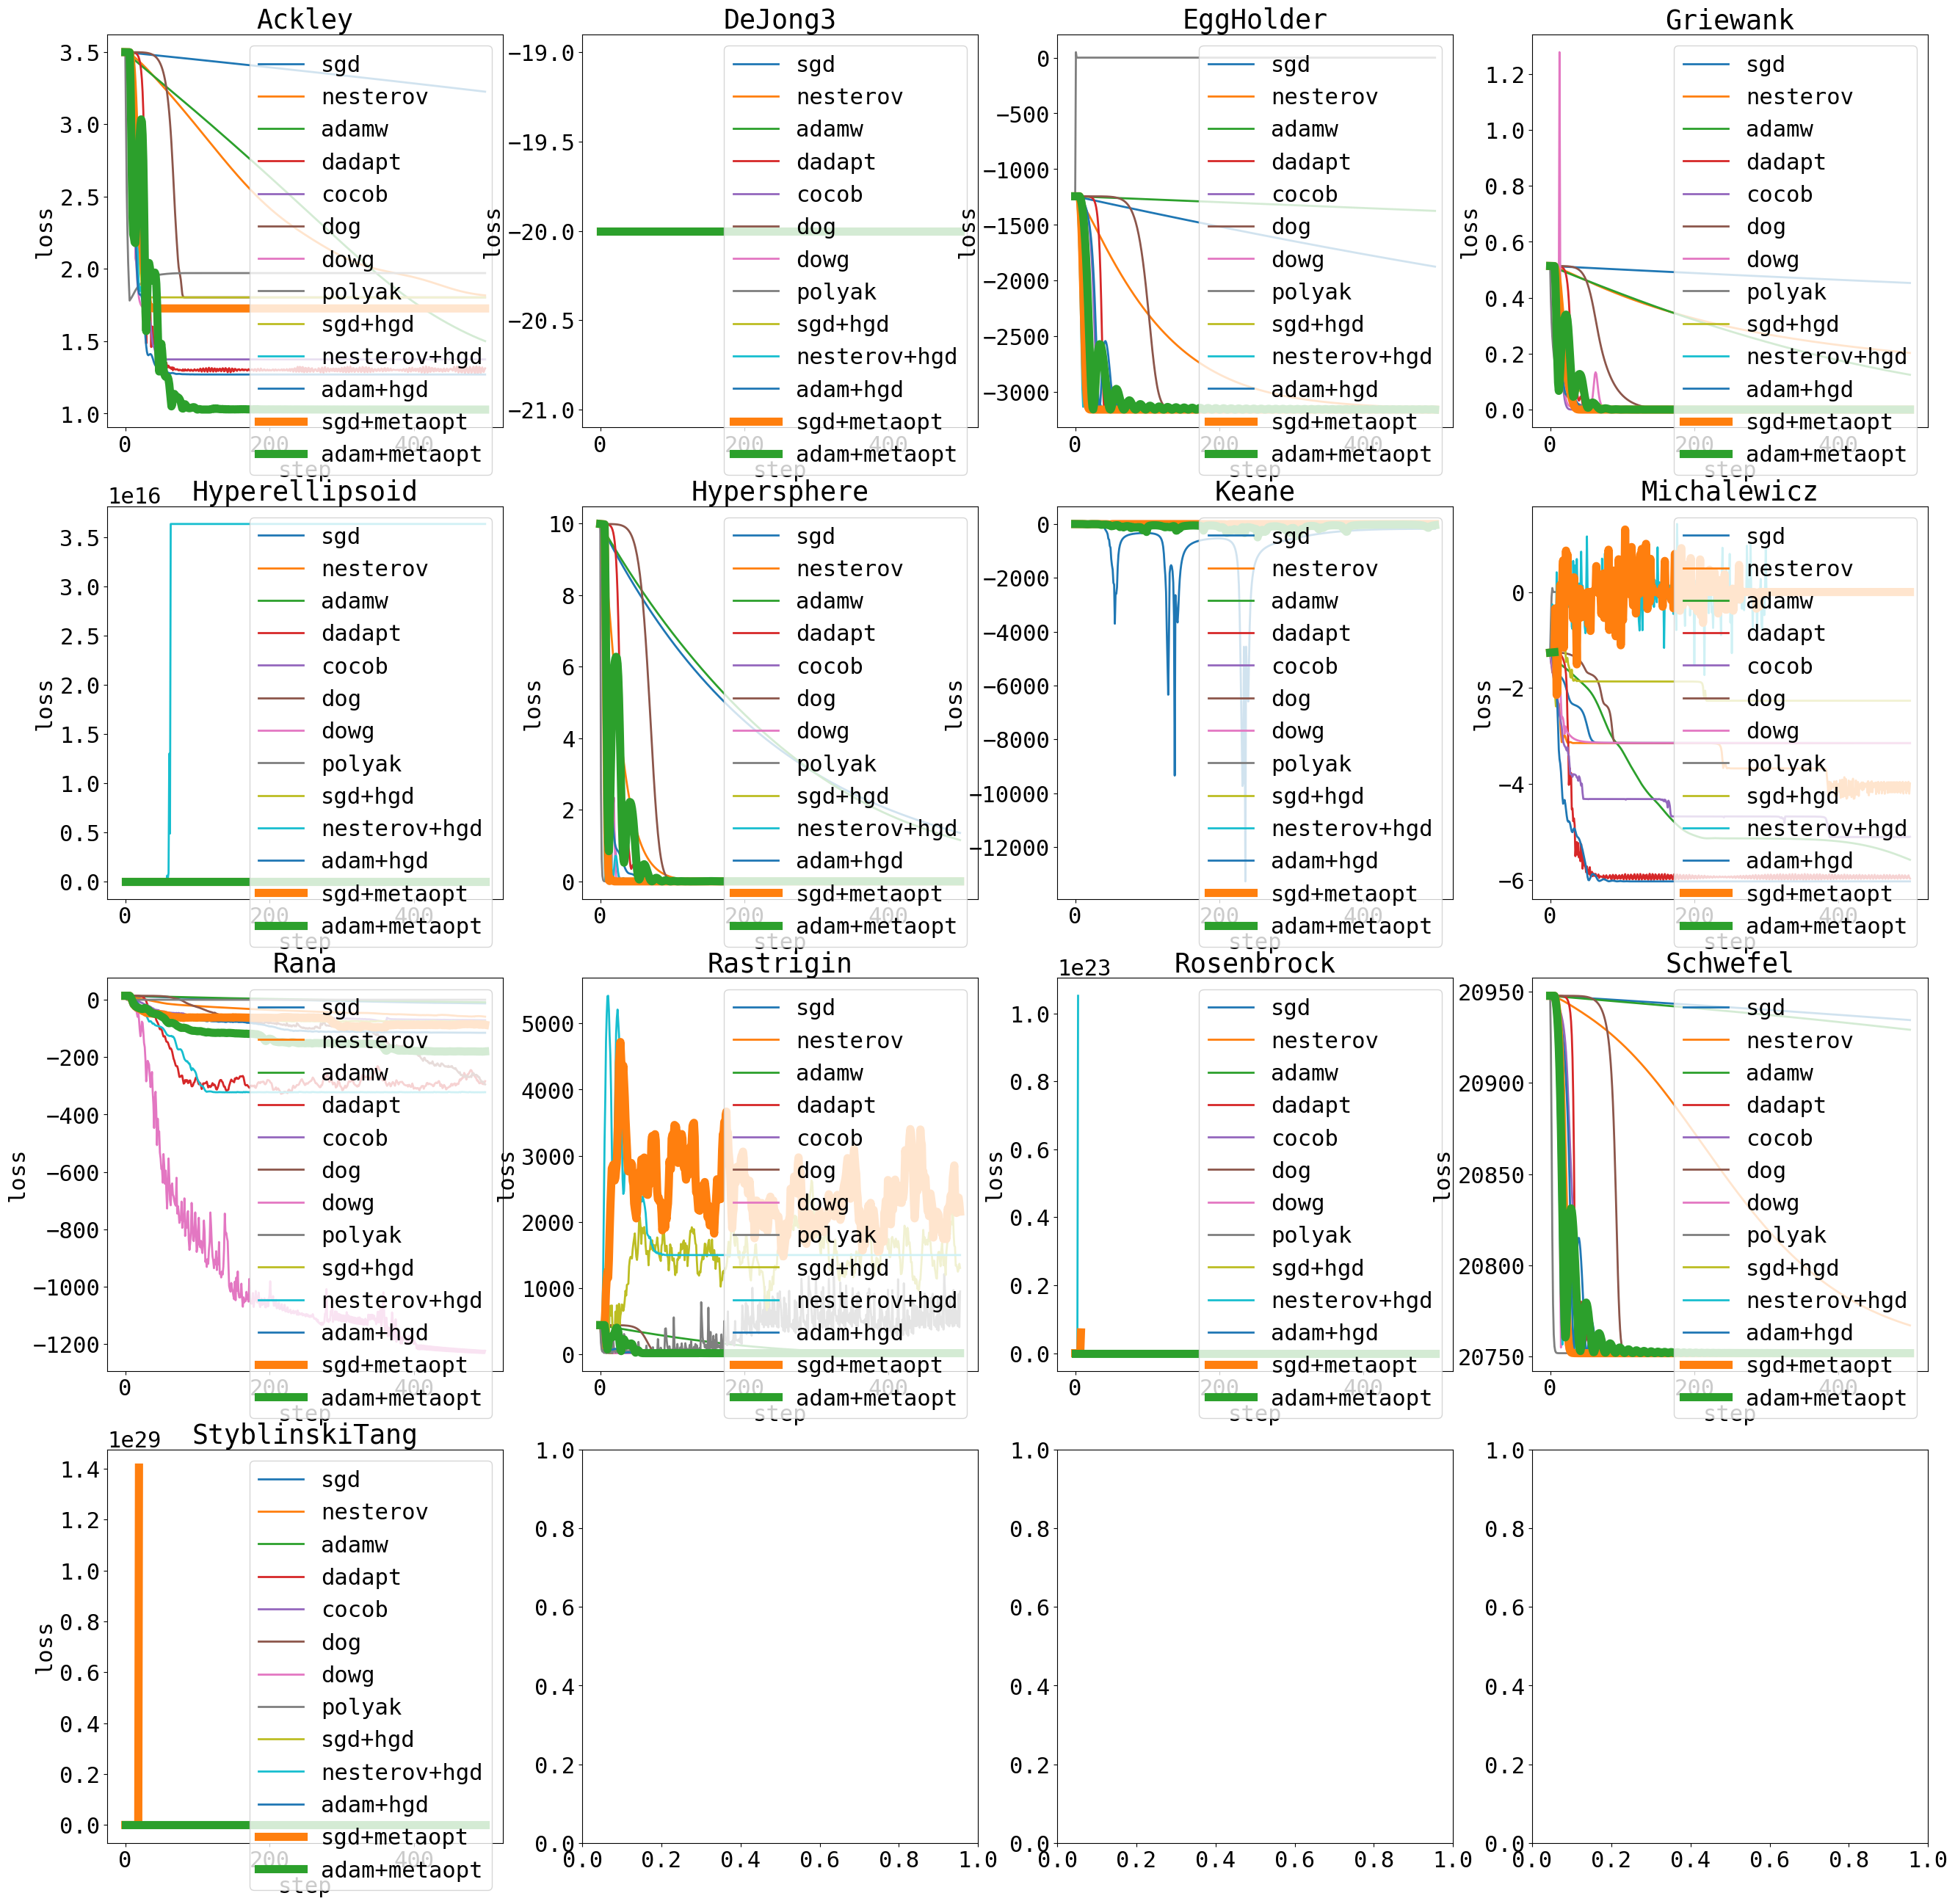

In [52]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'monospace',
        # 'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

from meta_opt.synthetic import benchmark
from meta_opt.optimizers import *
from meta_opt.optimizers.schedules import ConstantScheduleConfig

cfgs = {
    'sgd': SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.001)),
    'nesterov': SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.001), nesterov=True, momentum=0.9),
    'adamw': AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.001), b1=0.9, b2=0.9),
    'dadapt': DAdaptationConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1), b1=0.9, b2=0.9),
    'cocob': COCOBConfig(),
    'dog': DoGConfig(),
    'dowg': DoWGConfig(),
    'polyak': PolyakConfig(f_min=0),
    'sgd+hgd': SGDHGDConfig(meta_optimizer_cfg=COCOBConfig(), initial_lr=0.),
    'nesterov+hgd': SGDHGDConfig(meta_optimizer_cfg=COCOBConfig(), initial_lr=0., momentum=0.9, nesterov=True),
    'adam+hgd': AdamHGDConfig(meta_optimizer_cfg=COCOBConfig(), initial_lr=0., b1=0.9, b2=0.9),
    'sgd+metaopt': MetaOptConfig(base_learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0), 
                             scale_by_adam_betas=None, 
                             H=4, HH=2, m_method='diagonal', 
                             # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-4)),
                             meta_optimizer_cfg=COCOBConfig(),
                             # meta_optimizer_cfg=MechanicConfig(base_optimizer_cfg=COCOBConfig()),
                             # meta_optimizer_cfg=AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-4), b1=0.9, b2=0.9),
                             fake_the_dynamics=False, freeze_cost_fn_during_rollouts=False,
                             weight_decay=1e-4, grad_clip=None, freeze_gpc_params=None, use_bfloat16=False),
    'adam+metaopt': MetaOptConfig(base_learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0), 
                             scale_by_adam_betas=(0.9, 0.9), 
                             H=4, HH=2, m_method='diagonal', 
                             # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-4)),
                             meta_optimizer_cfg=COCOBConfig(),
                             # meta_optimizer_cfg=MechanicConfig(base_optimizer_cfg=COCOBConfig()),
                             # meta_optimizer_cfg=AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-4), b1=0.9, b2=0.9),
                             fake_the_dynamics=False, freeze_cost_fn_during_rollouts=False,
                             weight_decay=1e-4, grad_clip=None, freeze_gpc_params=None, use_bfloat16=False)
}
num_iters = 500
d = 50
seed = 1

results = defaultdict(dict)
for cfg_key, cfg in cfgs.items():
    print('running', cfg_key)
    ret = benchmark.test_opt(seed, cfg, d, num_iters)
    for k, v in ret.items():
        results[k][cfg_key] = v

n_fns = len(results)  # should be 13
h = int(n_fns ** 0.5) + 1
w = int((n_fns + h // 2 + 1) // h)
fig, ax = plt.subplots(h, w, figsize=(8*h, 8*w))

for i in range(h):
    for j in range(w):
        idx = i * w + j
        if idx >= len(results):
            break
        fn_name = list(results.keys())[idx]
        for k, v in results[fn_name].items():
            if 'metaopt' in k: linewidth = 8
            else: linewidth = 2
            ax[i, j].plot(range(num_iters), v, label=k, linewidth=linewidth)
        ax[i, j].set_xlabel('step')
        ax[i, j].set_ylabel('loss')
        ax[i, j].set_title(fn_name)
        ax[i, j].legend()
# plt.savefig('../figs/synthetic.png')

# Sweep hyperparams on a simple test function

In [46]:
from matplotlib import pyplot as plt
import functools

import jax
import jax.numpy as jnp
import optax

from meta_opt import optimizers as metaopt

NUM_STEPS = 500
NUM_TRIALS = 10
D = 10
COLORBAR_MIN, COLORBAR_MAX = -12, 2  # should be the max and min of `loss_fn`

# train functions
@jax.jit
def test_fn(x):
    return jnp.log(x ** 2 + 1 + jnp.sin(3*x)).sum() + 1.5
loss_fn = jax.tree_util.Partial(test_fn)

static_argnames = ('num_steps', 'd', 'num_trials')
@functools.partial(jax.jit, static_argnames=static_argnames[:2])
def outer_loss(seed, make_opt_cfg_fn, num_steps: int, d: int):
    opt_cfg = make_opt_cfg_fn()
    opt = opt_cfg.make_jax()
    value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
    x = jax.random.normal(jax.random.PRNGKey(seed), (d,))
    opt_state = opt.init(x)

    # handle metaopt for the scan
    if opt_cfg.optimizer_name == 'MetaOpt':
        opt_state = (opt_state[0].replace(cost_fn_history = (loss_fn,) * opt_cfg.HH), opt_state[1])

    def scan_fn(carry, _):
        x, opt_state = carry
        loss, grad = value_and_grad_fn(x)
        updates, opt_state = opt.update(grad, opt_state, x, cost_fn=loss_fn)
        x = optax.apply_updates(x, updates)
        return (x, opt_state), loss
    _, losses = jax.lax.scan(scan_fn, (x, opt_state), length=num_steps)
    ret = jnp.mean(jnp.asarray(losses))
    return ret

### Vanilla AdamW sweep over $(\eta, \beta_1)$

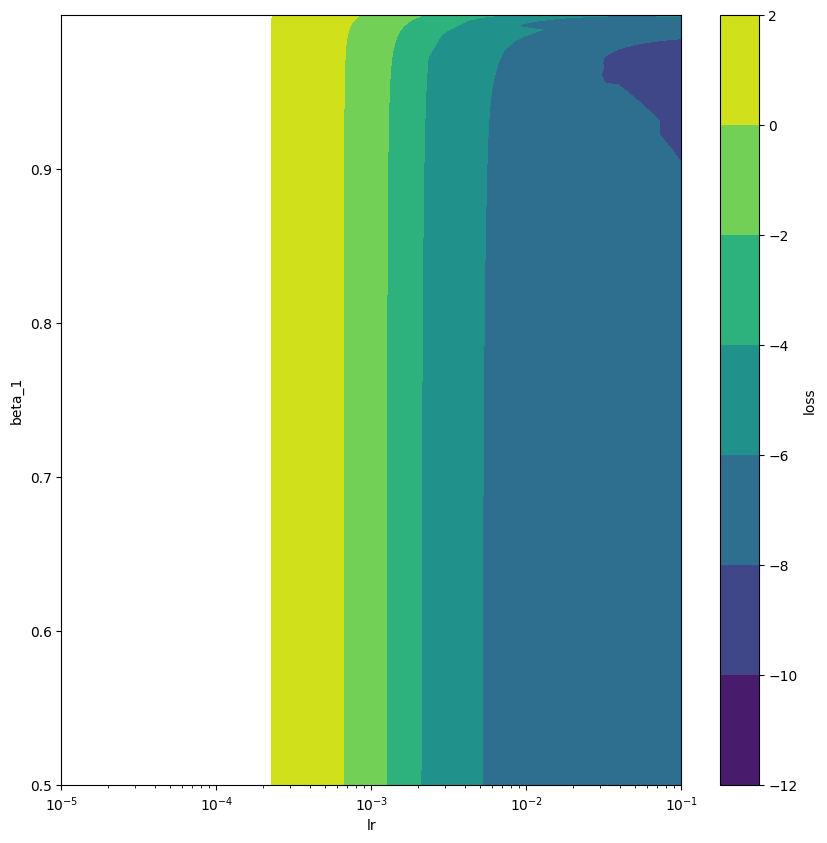

In [47]:
@functools.partial(jax.jit, static_argnames=static_argnames)
def run(lr: float, b1: float, b2: float, num_steps: int, d: int, num_trials: int):
    def make_cfg():
        return metaopt.AdamWConfig(learning_rate_schedule_cfg=metaopt.ConstantScheduleConfig(learning_rate=lr),
                                   b1=b1, b2=b2)
    return jnp.median(jnp.concatenate([jax.lax.scan(lambda _, s: (None, outer_loss(s, jax.tree_util.Partial(make_cfg), num_steps, d)), None, jnp.arange(num_trials))[1]], axis=0), axis=0)

# # sweep over lrs 
# lrs = jnp.logspace(-5, -1, 500)
# losses = jax.jit(jax.vmap(run, in_axes=(0, None, None, None, None,)), static_argnames=static_argnames)(lrs, 0.9, 0.999, NUM_STEPS, D)
# plt.semilogx(lrs, losses)
# plt.xlabel('lr')
# plt.ylabel('avg loss')

# sweep over (lr, b1)
lrs = jnp.logspace(-5, -1, 50)  # [0, 1]
b1s = 1 - jnp.logspace(-5, 0, 100) / 2  # [0.5, 1]
b2 = 0.9

ll, bb = jnp.meshgrid(lrs, b1s)
l_fn = jax.jit(jax.vmap(run, in_axes=(0, 0, None, None, None, None)), static_argnames=static_argnames)
losses = l_fn(ll.reshape(-1), bb.reshape(-1), b2, NUM_STEPS, D, NUM_TRIALS).reshape(b1s.shape[0], lrs.shape[0])

fix, ax = plt.subplots(1, 1, figsize=(10, 10))
v = jnp.linspace(COLORBAR_MIN, COLORBAR_MAX, 8, endpoint=True)
h = ax.contourf(ll, bb, losses, v)
ax.set_xscale('log')
ax.set_xlabel('lr')
ax.set_ylabel('beta_1')
plt.colorbar(h, ax=ax, label='loss', ticks=v)
plt.show();

### Adam + HGD sweep over $(\eta_\text{meta}, \beta_1)$ with $\eta_\text{initial}=0$

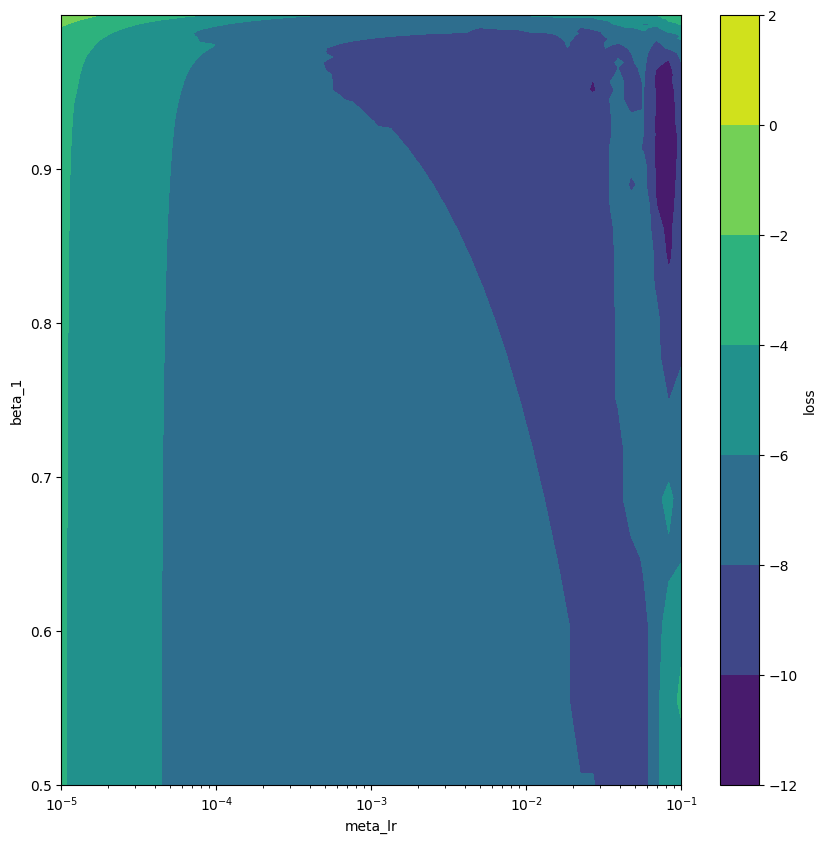

In [48]:
@functools.partial(jax.jit, static_argnames=static_argnames)
def run(meta_lr: float, b1: float, b2: float, num_steps: int, d: int, num_trials: int):
    def make_cfg():
        meta_cfg = metaopt.SGDConfig(learning_rate_schedule_cfg=metaopt.ConstantScheduleConfig(learning_rate=meta_lr))
        return metaopt.AdamHGDConfig(meta_optimizer_cfg=meta_cfg, initial_lr=0., b1=b1, b2=b2)
    return jnp.median(jnp.concatenate([jax.lax.scan(lambda _, s: (None, outer_loss(s, jax.tree_util.Partial(make_cfg), num_steps, d)), None, jnp.arange(num_trials))[1]], axis=0), axis=0)

# # sweep over lrs 
# lrs = jnp.logspace(-5, -1, 500)
# losses = jax.jit(jax.vmap(run, in_axes=(0, None, None, None, None,)), static_argnames=static_argnames)(lrs, 0.9, 0.999, NUM_STEPS, D)
# plt.semilogx(lrs, losses)
# plt.xlabel('lr')
# plt.ylabel('avg loss')

# sweep over (meta_lr, b1)
lrs = jnp.logspace(-5, -1, 50)  # [0, 1]
b1s = 1 - jnp.logspace(-5, 0, 100) / 2  # [0.5, 1]
b2 = 0.9

ll, bb = jnp.meshgrid(lrs, b1s)
l_fn = jax.jit(jax.vmap(run, in_axes=(0, 0, None, None, None, None)), static_argnames=static_argnames)
losses = l_fn(ll.reshape(-1), bb.reshape(-1), b2, NUM_STEPS, D, NUM_TRIALS).reshape(b1s.shape[0], lrs.shape[0])

fix, ax = plt.subplots(1, 1, figsize=(10, 10))
v = jnp.linspace(COLORBAR_MIN, COLORBAR_MAX, 8, endpoint=True)
h = ax.contourf(ll, bb, losses, v)
ax.set_xscale('log')
ax.set_xlabel('meta_lr')
ax.set_ylabel('beta_1')
plt.colorbar(h, ax=ax, label='loss', ticks=v)
plt.show();

### Adam + metaopt sweep over $(\eta_\text{meta}, \beta_1)$ with $\eta_\text{initial}=0$

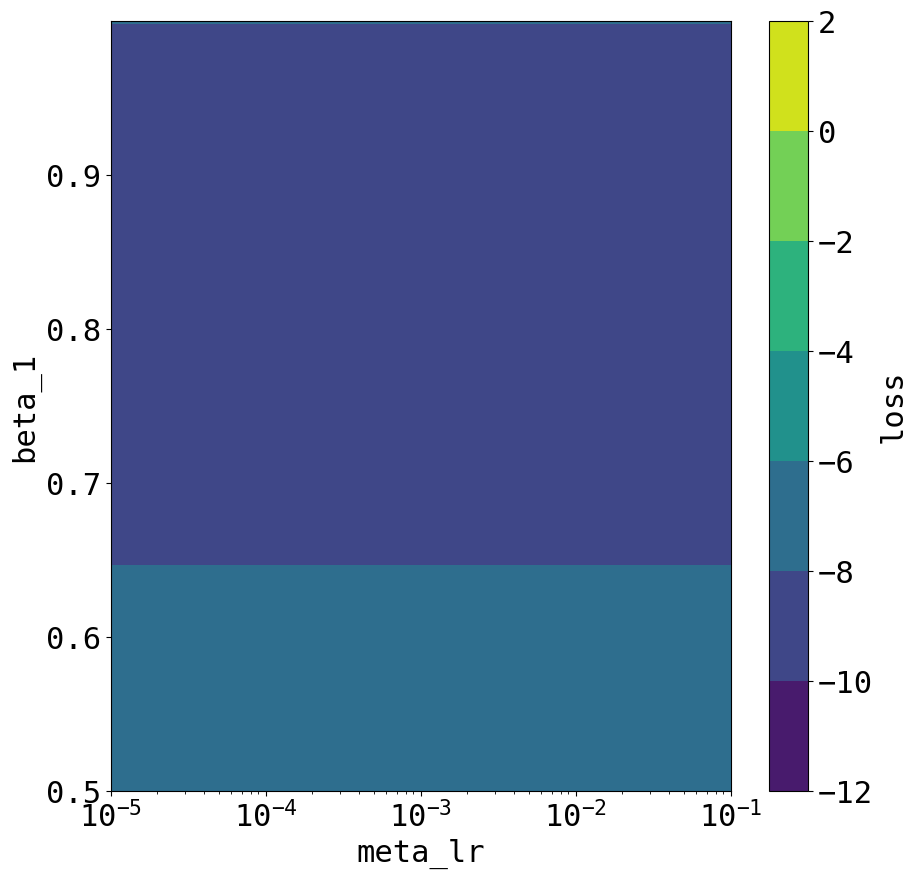

In [55]:
RATIO = 10

@functools.partial(jax.jit, static_argnames=static_argnames+('H', 'HH',))
def run(meta_lr: float, b1: float, b2: float, num_steps: int, d: int, num_trials: int, H: int = 3, HH: int = 3):
    def make_cfg():
        # meta_cfg = metaopt.SGDConfig(learning_rate_schedule_cfg=metaopt.ConstantScheduleConfig(learning_rate=meta_lr))
        meta_cfg = COCOBConfig()
        return metaopt.MetaOptConfig(base_learning_rate_schedule_cfg = ConstantScheduleConfig(learning_rate=0),
                                     weight_decay = 1e-4,
                                     grad_clip = None,
                                     scale_by_adam_betas = (b1, b2),
                                     
                                     H = H,
                                     HH = HH,
                                     m_method = 'scalar',
                                     fake_the_dynamics = False,
                                     freeze_cost_fn_during_rollouts = False,
                                    
                                     freeze_gpc_params = False,
                                     use_bfloat16 = False,
                                     meta_optimizer_cfg = meta_cfg)
    return jnp.median(jnp.concatenate([jax.lax.scan(lambda _, s: (None, outer_loss(s, jax.tree_util.Partial(make_cfg), num_steps, d)), None, jnp.arange(num_trials))[1]], axis=0), axis=0)

# # sweep over meta_lrs 
# lrs = jnp.logspace(-5, -1, 500)
# losses = jax.jit(jax.vmap(run, in_axes=(0, None, None, None, None)), static_argnames=static_argnames)(lrs, 0.9, 0.9, NUM_STEPS, D)
# plt.semilogx(lrs, losses)
# plt.xlabel('meta lr')
# plt.ylabel('avg loss')

# sweep over (meta_lr, b1)
lrs = jnp.logspace(-5, -1, 50 // RATIO)  # [0, 1]
b1s = 1 - jnp.logspace(-5, 0, 100 // RATIO) / 2  # [0.5, 1]
b2 = 0.9

ll, bb = jnp.meshgrid(lrs, b1s)
l_fn = jax.jit(jax.vmap(run, in_axes=(0, 0, None, None, None, None)), static_argnames=static_argnames)
losses = l_fn(ll.reshape(-1), bb.reshape(-1), b2, NUM_STEPS, D, NUM_TRIALS).reshape(b1s.shape[0], lrs.shape[0])

fix, ax = plt.subplots(1, 1, figsize=(10, 10))
v = jnp.linspace(COLORBAR_MIN, COLORBAR_MAX, 8, endpoint=True)
h = ax.contourf(ll, bb, losses, v)
ax.set_xscale('log')
ax.set_xlabel('meta_lr')
ax.set_ylabel('beta_1')
plt.colorbar(h, ax=ax, label='loss', ticks=v)
plt.show();